
# 2 and 3 species Competitive Lotka-Volterra

Adapted from the numpyro predator-prey example
http://num.pyro.ai/en/stable/examples/ode.html


In [1]:
import argparse
import os

import matplotlib
import matplotlib.pyplot as plt

from jax.experimental.ode import odeint
import jax.numpy as jnp
from jax.random import PRNGKey

import numpyro
import numpyro.distributions as dist
from numpyro.examples.datasets import LYNXHARE, load_dataset
from numpyro.infer import MCMC, NUTS, Predictive

import pandas as pd
import numpy as np

numpyro.set_host_device_count(2)

###   2-species

In [3]:
#Recover parameters via inference from data from mathematica simulation for 2 species:
df=pd.read_csv("data/sim.csv", header = None)
week = np.array(df.iloc[:,0])
data = np.array([df.iloc[:,1],df.iloc[:,2]]).T

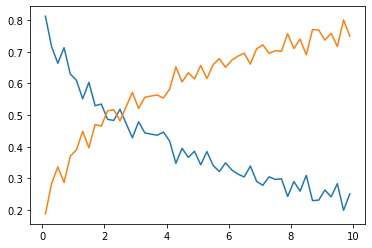

In [5]:
plt.plot(week, data[:, 0])
plt.plot(week, data[:, 1])
plt.show()

In [6]:
def dz_dt(z, t, theta):

    z1 = z[0]
    z2 = z[1]
    a11, a12, a21, a22 = (
        theta[..., 0],
        theta[..., 1],
        theta[..., 2],
        theta[..., 3],
    )
    dz1_dt = z1 * (1 - (a11 * z1 + a12 * z2))
    dz2_dt = z2 * (1 - (a21 * z1 + a22 * z2))
    return jnp.stack([dz1_dt, dz2_dt])


def model(N, y=None):
    """
    :param int N: number of measurement times
    :param numpy.ndarray y: measured populations with shape (N, 2)
    """
    # initial population
    z_init = numpyro.sample("z_init", dist.LogNormal(jnp.log(10), 1).expand([2]))
    ts = jnp.arange(float(N))
    theta = numpyro.sample(
        "theta",
        dist.TruncatedNormal(
            low=0.0,
            loc=jnp.array([1.0, 1.0, 1.0, 1.0]),
            scale=jnp.array([0.25, 0.25, 0.25, 0.25]),
        ),
    )
    z = odeint(dz_dt, z_init, ts, theta, rtol=1e-6, atol=1e-5, mxstep=1000)
    sigma = numpyro.sample("sigma", dist.LogNormal(-1, 1).expand([2]))
    # measured populations
    numpyro.sample("y", dist.LogNormal(jnp.log(z), sigma), obs=y)
mcmc = MCMC(
    NUTS(model, dense_mass=True),
    500,
    500,
    num_chains=2,
    progress_bar=False if "NUMPYRO_SPHINXBUILD" in os.environ else True,
)
mcmc.run(PRNGKey(1), N=data.shape[0], y=data)
mcmc.print_summary()




                mean       std    median      5.0%     95.0%     n_eff     r_hat
  sigma[0]      0.09      0.01      0.09      0.07      0.11   1120.23      1.00
  sigma[1]      0.06      0.01      0.06      0.05      0.07    806.07      1.00
  theta[0]      1.01      0.04      1.01      0.95      1.07   1029.37      1.00
  theta[1]      1.03      0.02      1.03      0.99      1.06   1247.82      1.00
  theta[2]      0.84      0.04      0.84      0.78      0.90   1033.80      1.00
  theta[3]      1.07      0.02      1.07      1.03      1.10   1273.03      1.00
 z_init[0]      0.64      0.05      0.64      0.57      0.72    854.41      1.00
 z_init[1]      0.23      0.01      0.23      0.21      0.25    734.56      1.00

Number of divergences: 0


In [7]:
pop_pred = Predictive(model, mcmc.get_samples())(PRNGKey(2), data.shape[0])["y"]
mu, pi = jnp.mean(pop_pred, 0), jnp.percentile(pop_pred, (10, 90), 0)

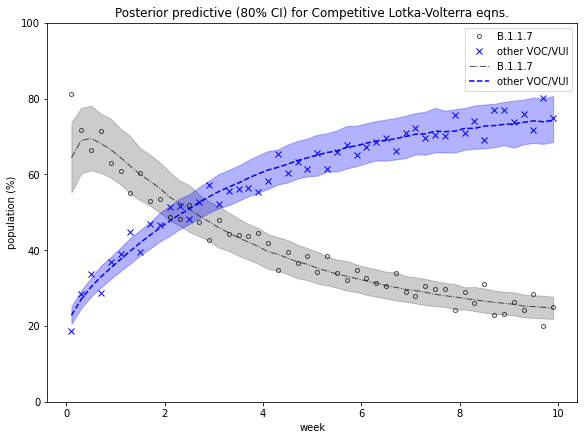

In [10]:
plt.figure(figsize=(8, 6), constrained_layout=True)
plt.plot(week, 100 * data[:, 0], "ko", mfc="none", ms=4, label="B.1.1.7", alpha=0.67)
plt.plot(week, 100 * data[:, 1], "bx", label="other VOC/VUI")
plt.plot(week, 100 * mu[:, 0], "k-.", label="B.1.1.7", lw=1, alpha=0.67)
plt.plot(week, 100 * mu[:, 1], "b--", label="other VOC/VUI")
plt.fill_between(week, 100 * pi[0, :, 0], 100 * pi[1, :, 0], color="k", alpha=0.2)
plt.fill_between(week, 100 * pi[0, :, 1], 100 * pi[1, :, 1], color="b", alpha=0.3)
plt.gca().set(ylim=(0, 100), xlabel="week", ylabel="population (%)")
plt.title("Posterior predictive (80% CI) for Competitive Lotka-Volterra eqns.")
plt.legend()
plt.show()

### 3-species

In [11]:
#Recover parameters via inference from data from mathematica simulation for 3 species:
df=pd.read_csv("data/sim3.csv", header = None)
week = np.array(df.iloc[:,0])
data = np.array([df.iloc[:,1],df.iloc[:,2],df.iloc[:,3]]).T

In [12]:
def dz_dt(z, t, theta):

    z1 = z[0]
    z2 = z[1]
    z3 = z[2]
    a11, a12, a13, a21, a22, a23, a31, a32, a33 = (
        theta[..., 0],
        theta[..., 1],
        theta[..., 2],
        theta[..., 3],
        theta[..., 4],
        theta[..., 5],
        theta[..., 6],
        theta[..., 7],
        theta[..., 8]
    )
    dz1_dt = z1 * (1 - (a11 * z1 + a12 * z2 + a13 * z3))
    dz2_dt = z2 * (1 - (a21 * z1 + a22 * z2 + a23 * z3))
    dz3_dt = z3 * (1 - (a31 * z1 + a32 * z2 + a33 * z3))
    return jnp.stack([dz1_dt, dz2_dt, dz3_dt])


def model(N, y=None):
    # initial population
    z_init = numpyro.sample("z_init", dist.LogNormal(jnp.log(10), 1).expand([3]))
    # measurement times
    ts = jnp.arange(float(N))
    theta = numpyro.sample(
        "theta",
        dist.TruncatedNormal(
            low=0.0,
            loc=jnp.array([1.0, 1.0, 1.0, 1.0,1.0,1.0, 1.0,1.0,1.0]),
            scale=jnp.array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]),
        ),
    )
    z = odeint(dz_dt, z_init, ts, theta, rtol=1e-7, atol=1e-6, mxstep=1000)
    sigma = numpyro.sample("sigma", dist.LogNormal(-1, 1).expand([3]))
    numpyro.sample("y", dist.LogNormal(jnp.log(z), sigma), obs=y)
    
mcmc = MCMC(
    NUTS(model, dense_mass=True),
    500,
    500,
    num_chains=2,
    progress_bar=False if "NUMPYRO_SPHINXBUILD" in os.environ else True,
)

mcmc.run(PRNGKey(1), N=data.shape[0], y=data)
mcmc.print_summary()




                mean       std    median      5.0%     95.0%     n_eff     r_hat
  sigma[0]      0.94      0.09      0.94      0.79      1.09    943.28      1.00
  sigma[1]      0.12      0.01      0.12      0.10      0.14    580.68      1.00
  sigma[2]      0.18      0.02      0.18      0.16      0.22    697.60      1.00
  theta[0]      0.99      0.22      0.98      0.63      1.33    731.33      1.00
  theta[1]      1.06      0.05      1.06      0.97      1.14    644.25      1.00
  theta[2]      1.27      0.09      1.27      1.12      1.40    577.76      1.00
  theta[3]      0.98      0.21      0.97      0.63      1.29    675.94      1.00
  theta[4]      1.01      0.03      1.01      0.95      1.06    634.26      1.00
  theta[5]      0.90      0.06      0.90      0.80      1.01    503.70      1.00
  theta[6]      0.67      0.17      0.66      0.39      0.93    592.05      1.00
  theta[7]      1.13      0.04      1.13      1.07      1.19    682.68      1.00
  theta[8]      1.03     

In [14]:
pop_pred = Predictive(model, mcmc.get_samples())(PRNGKey(2), data.shape[0])["y"]
mu, pi = jnp.mean(pop_pred, 0), jnp.percentile(pop_pred, (10, 90), 0)

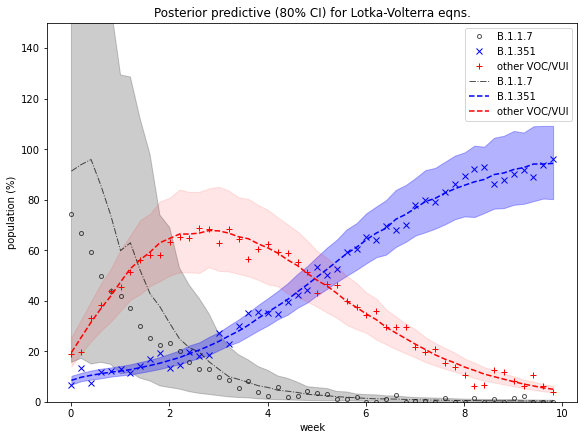

In [15]:
plt.figure(figsize=(8, 6), constrained_layout=True)
plt.plot(week, 100 * data[:, 0], "ko", mfc="none", ms=4, label="B.1.1.7", alpha=0.67)
plt.plot(week, 100 * data[:, 1], "bx", label="B.1.351")
plt.plot(week, 100 * data[:, 2], "r+", label="other VOC/VUI")
plt.plot(week, 100 * mu[:, 0], "k-.", label="B.1.1.7", lw=1, alpha=0.67)
plt.plot(week, 100 * mu[:, 1], "b--", label="B.1.351")
plt.plot(week, 100 * mu[:, 2], "r--", label="other VOC/VUI")
# plt.plot(week, mu[:, 0]+mu[:, 1]+mu[:, 2], "g--", label="Sum", alpha=0.2)
plt.fill_between(week, 100 * pi[0, :, 0], 100 * pi[1, :, 0], color="k", alpha=0.2)
plt.fill_between(week, 100 * pi[0, :, 1], 100 * pi[1, :, 1], color="b", alpha=0.3)
plt.fill_between(week, 100 * pi[0, :, 2], 100 * pi[1, :, 2], color="r", alpha=0.1)
# plt.fill_between(week, pi[0, :, 0]+pi[0, :, 1]+pi[0, :, 2], 
#                  pi[1, :, 0]+pi[1, :, 1]+pi[1, :, 2], color="g", alpha=0.1)
plt.gca().set(ylim=(0, 150), xlabel="week", ylabel="population (%)")
plt.title("Posterior predictive (80% CI) for Lotka-Volterra eqns.")
plt.legend()
plt.show()

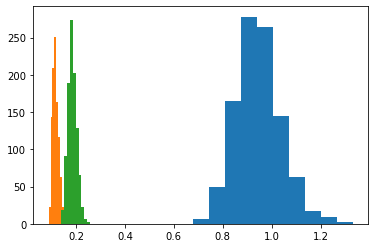

In [16]:
plt.hist(mcmc.get_samples()['sigma'].T[0])
plt.hist(mcmc.get_samples()['sigma'].T[1])
plt.hist(mcmc.get_samples()['sigma'].T[2])
plt.show()

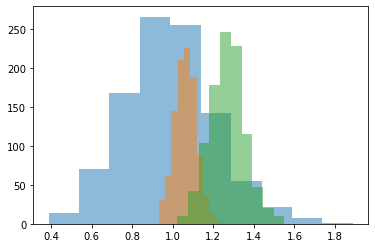

In [17]:
plt.hist(mcmc.get_samples()['theta'].T[0],alpha=0.5)
plt.hist(mcmc.get_samples()['theta'].T[1],alpha=0.5)
plt.hist(mcmc.get_samples()['theta'].T[2],alpha=0.5)
plt.show()

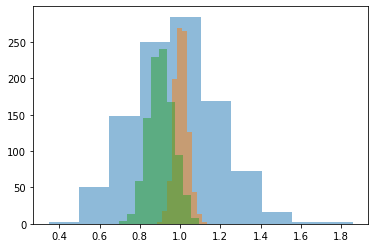

In [18]:
plt.hist(mcmc.get_samples()['theta'].T[3],alpha=0.5)
plt.hist(mcmc.get_samples()['theta'].T[4],alpha=0.5)
plt.hist(mcmc.get_samples()['theta'].T[5],alpha=0.5)
plt.show()

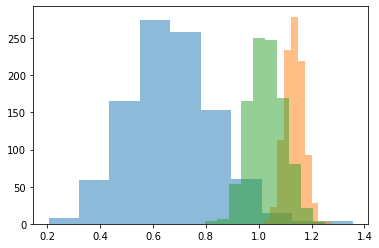

In [19]:
plt.hist(mcmc.get_samples()['theta'].T[6],alpha=0.5)
plt.hist(mcmc.get_samples()['theta'].T[7],alpha=0.5)
plt.hist(mcmc.get_samples()['theta'].T[8],alpha=0.5)
plt.show()

Hmm, for some reason the B117-labelled eqn is more biased and has much more uncertainty than the others. One easy way around that's to pick up that equation implicitly via the sum condition rather than the inferred parameters:

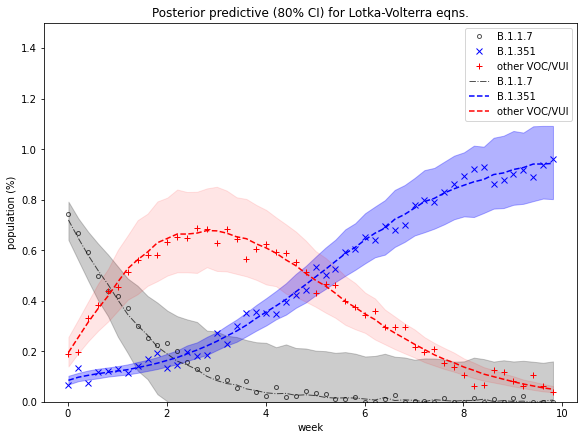

In [20]:
plt.figure(figsize=(8, 6), constrained_layout=True)
plt.plot(week, data[:, 0], "ko", mfc="none", ms=4, label="B.1.1.7", alpha=0.67)
plt.plot(week, data[:, 1], "bx", label="B.1.351")
plt.plot(week, data[:, 2], "r+", label="other VOC/VUI")
plt.plot(week, 1-mu[:, 1]-mu[:, 2], "k-.", label="B.1.1.7", lw=1, alpha=0.67)
plt.plot(week, mu[:, 1], "b--", label="B.1.351")
plt.plot(week, mu[:, 2], "r--", label="other VOC/VUI")
# plt.plot(week, mu[:, 0]+mu[:, 1]+mu[:, 2], "g--", label="Sum", alpha=0.2)
plt.fill_between(week, 1-pi[0, :, 1]-pi[0, :, 2], 1-pi[1, :, 1]-pi[1, :, 2], color="k", alpha=0.2)
plt.fill_between(week, pi[0, :, 1], pi[1, :, 1], color="b", alpha=0.3)
plt.fill_between(week, pi[0, :, 2], pi[1, :, 2], color="r", alpha=0.1)
# plt.fill_between(week, pi[0, :, 0]+pi[0, :, 1]+pi[0, :, 2], 
#                  pi[1, :, 0]+pi[1, :, 1]+pi[1, :, 2], color="g", alpha=0.1)
plt.gca().set(ylim=(0, 1.5), xlabel="week", ylabel="population (%)")
plt.title("Posterior predictive (80% CI) for Lotka-Volterra eqns.")
plt.legend()
plt.show()

Somewhat nicer, but still, this doesn't seem satisfactory in terms of why does it happen.

Let's just check if defining the B.1.1.7 eqn via the sum rule during inference gives the same as the post-processing way above.

In [21]:
def dz_dt(z, t, theta):

    z1 = z[0]
    z2 = z[1]
    z3 = z[2]
    a11, a12, a13, a21, a22, a23 = (
        theta[..., 0],
        theta[..., 1],
        theta[..., 2],
        theta[..., 3],
        theta[..., 4],
        theta[..., 5]
    )
    dz1_dt = z1 * (1 - (a11 * z1 + a12 * z2 + a13 * z3))
    dz2_dt = z2 * (1 - (a21 * z1 + a22 * z2 + a23 * z3))
    dz3_dt = -dz1_dt - dz2_dt
    return jnp.stack([dz1_dt, dz2_dt, dz3_dt])


def model(N, y=None):
    # initial population
    z_init = numpyro.sample("z_init", dist.LogNormal(jnp.log(10), 1).expand([3]))
    # measurement times
    ts = jnp.arange(float(N))
    theta = numpyro.sample(
        "theta",
        dist.TruncatedNormal(
            low=0.0,
            loc=jnp.array([1.0, 1.0, 1.0, 1.0,1.0,1.0]),
            scale=jnp.array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5]),
        ),
    )
    z = odeint(dz_dt, z_init, ts, theta, rtol=1e-7, atol=1e-6, mxstep=1000)
    sigma = numpyro.sample("sigma", dist.LogNormal(-1, 1).expand([3]))
#     sigma = numpyro.sample("sigma", dist.Normal(0.1, 0.1).expand([3]))
    numpyro.sample("y", dist.LogNormal(jnp.log(z), sigma), obs=y)
    
mcmc = MCMC(
    NUTS(model, dense_mass=True),
    500,
    500,
    num_chains=2,
    progress_bar=False if "NUMPYRO_SPHINXBUILD" in os.environ else True,
)

mcmc.run(PRNGKey(1), N=data.shape[0], y=data)
mcmc.print_summary()




                mean       std    median      5.0%     95.0%     n_eff     r_hat
  sigma[0]      0.95      0.10      0.94      0.78      1.09    578.28      1.00
  sigma[1]      0.12      0.01      0.12      0.10      0.14    949.89      1.00
  sigma[2]      0.18      0.02      0.18      0.15      0.22    796.83      1.00
  theta[0]      1.05      0.05      1.05      0.97      1.13    550.72      1.00
  theta[1]      1.07      0.04      1.07      1.00      1.13    692.91      1.00
  theta[2]      1.25      0.04      1.25      1.18      1.32    588.33      1.01
  theta[3]      1.02      0.03      1.02      0.97      1.07    710.61      1.00
  theta[4]      1.01      0.02      1.01      0.98      1.04    789.16      1.00
  theta[5]      0.89      0.02      0.89      0.86      0.91    843.08      1.00
 z_init[0]      0.69      0.04      0.69      0.63      0.75    421.84      1.01
 z_init[1]      0.10      0.01      0.10      0.08      0.11    803.37      1.00
 z_init[2]      0.20     

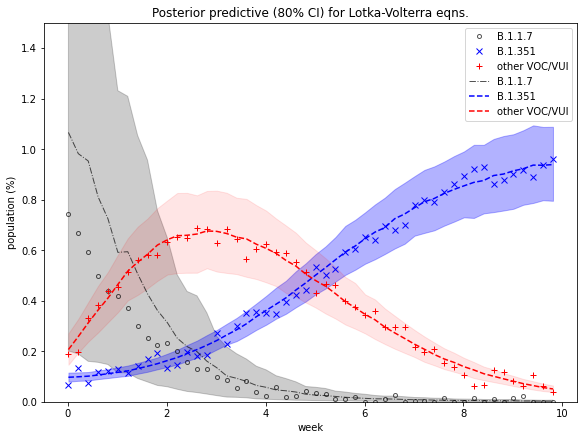

In [23]:
pop_pred = Predictive(model, mcmc.get_samples())(PRNGKey(2), data.shape[0])["y"]
mu, pi = jnp.mean(pop_pred, 0), jnp.percentile(pop_pred, (10, 90), 0)

plt.figure(figsize=(8, 6), constrained_layout=True)
plt.plot(week, data[:, 0], "ko", mfc="none", ms=4, label="B.1.1.7", alpha=0.67)
plt.plot(week, data[:, 1], "bx", label="B.1.351")
plt.plot(week, data[:, 2], "r+", label="other VOC/VUI")
plt.plot(week, mu[:, 0], "k-.", label="B.1.1.7", lw=1, alpha=0.67)
plt.plot(week, mu[:, 1], "b--", label="B.1.351")
plt.plot(week, mu[:, 2], "r--", label="other VOC/VUI")
# plt.plot(week, mu[:, 0]+mu[:, 1]+mu[:, 2], "g--", label="Sum", alpha=0.2)
plt.fill_between(week, pi[0, :, 0], pi[1, :, 0], color="k", alpha=0.2)
plt.fill_between(week, pi[0, :, 1], pi[1, :, 1], color="b", alpha=0.3)
plt.fill_between(week, pi[0, :, 2], pi[1, :, 2], color="r", alpha=0.1)
# plt.fill_between(week, pi[0, :, 0]+pi[0, :, 1]+pi[0, :, 2], 
#                  pi[1, :, 0]+pi[1, :, 1]+pi[1, :, 2], color="g", alpha=0.1)
plt.gca().set(ylim=(0, 1.5), xlabel="week", ylabel="population (%)")
plt.title("Posterior predictive (80% CI) for Lotka-Volterra eqns.")
plt.legend()
plt.show()

Curious, this is just as bad as the normal inference way for the B.1.1.7 eqn. Maybe this has to do with the non-linearity, and and likelihood mis-specification. Probs adapting the likelihood and priors is best but I bet it works if we just run things for no very small values of population, so say only up to week 5:

Run it for a shorter amount of time to see if it is the uncertainty mis-specification for when population goes to zero that is messing things up

In [24]:
week_short, data_short = week[0:29], data[0:29]

In [25]:
def dz_dt(z, t, theta):

    z1 = z[0]
    z2 = z[1]
    z3 = z[2]
    a1, a11, a12, a13, a21, a2, a22, a23, a3, a31, a32, a33 = (
        theta[..., 0],
        theta[..., 1],
        theta[..., 2],
        theta[..., 3],
        theta[..., 4],
        theta[..., 5],
        theta[..., 6],
        theta[..., 7],
        theta[..., 8],
        theta[..., 9],
        theta[..., 10],
        theta[..., 11]
    )
    dz1_dt = a1 * z1 * (1 - (a11 * z1 + a12 * z2 + a13 * z3))
    dz2_dt = a2 * z2 * (1 - (a21 * z1 + a22 * z2 + a23 * z3))
    dz3_dt = a3 * z3 * (1 - (a31 * z1 + a32 * z2 + a33 * z3))
    return jnp.stack([dz1_dt, dz2_dt, dz3_dt])


def model(N, y=None):
    # initial population
    z_init = numpyro.sample("z_init", dist.LogNormal(jnp.log(10), 1).expand([3]))
    # measurement times
    ts = jnp.arange(float(N))
    theta = numpyro.sample(
        "theta",
        dist.TruncatedNormal(
            low=0.0,
            loc=jnp.array([1.0, 1.0, 1.0, 1.0,1.0,1.0, 1.0,1.0,1.0, 1.0,1.0,1.0]),
            scale=jnp.array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]),
        ),
    )
    z = odeint(dz_dt, z_init, ts, theta, rtol=1e-7, atol=1e-6, mxstep=1000)
    sigma = numpyro.sample("sigma", dist.LogNormal(-1, 1).expand([3]))
    numpyro.sample("y", dist.LogNormal(jnp.log(z), sigma), obs=y)
    
mcmc = MCMC(
    NUTS(model, dense_mass=True),
    500,
    500,
    num_chains=2,
    progress_bar=False if "NUMPYRO_SPHINXBUILD" in os.environ else True,
)

mcmc.run(PRNGKey(1), N=data_short.shape[0], y=data_short)
mcmc.print_summary()




                mean       std    median      5.0%     95.0%     n_eff     r_hat
  sigma[0]      0.33      0.05      0.32      0.26      0.40    210.65      1.01
  sigma[1]      0.16      0.02      0.16      0.12      0.19     30.59      1.07
  sigma[2]      0.07      0.01      0.07      0.06      0.09    237.68      1.02
  theta[0]      0.70      0.38      0.61      0.23      1.31     63.46      1.03
  theta[1]      1.15      0.18      1.13      0.90      1.47    229.07      1.01
  theta[2]      1.27      0.23      1.26      0.92      1.63     40.07      1.03
  theta[3]      1.33      0.25      1.28      1.02      1.71     38.91      1.09
  theta[4]      0.90      0.20      0.92      0.60      1.24    184.38      1.02
  theta[5]      0.46      0.28      0.37      0.10      0.88     17.63      1.10
  theta[6]      0.87      0.21      0.89      0.55      1.24    242.49      1.01
  theta[7]      0.71      0.22      0.78      0.38      0.99     51.72      1.03
  theta[8]      1.03     

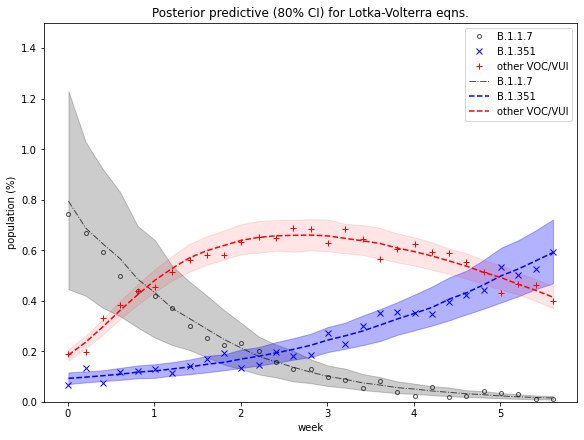

In [26]:
pop_pred = Predictive(model, mcmc.get_samples())(PRNGKey(2), data_short.shape[0])["y"]
mu, pi = jnp.mean(pop_pred, 0), jnp.percentile(pop_pred, (10, 90), 0)

plt.figure(figsize=(8, 6), constrained_layout=True)
plt.plot(week_short, data_short[:, 0], "ko", mfc="none", ms=4, label="B.1.1.7", alpha=0.67)
plt.plot(week_short, data_short[:, 1], "bx", label="B.1.351")
plt.plot(week_short, data_short[:, 2], "r+", label="other VOC/VUI")
plt.plot(week_short, mu[:, 0], "k-.", label="B.1.1.7", lw=1, alpha=0.67)
plt.plot(week_short, mu[:, 1], "b--", label="B.1.351")
plt.plot(week_short, mu[:, 2], "r--", label="other VOC/VUI")
plt.fill_between(week_short, pi[0, :, 0], pi[1, :, 0], color="k", alpha=0.2)
plt.fill_between(week_short, pi[0, :, 1], pi[1, :, 1], color="b", alpha=0.3)
plt.fill_between(week_short, pi[0, :, 2], pi[1, :, 2], color="r", alpha=0.1)
plt.gca().set(ylim=(0, 1.5), xlabel="week", ylabel="population (%)")
plt.title("Posterior predictive (80% CI) for Lotka-Volterra eqns.")
plt.legend()
plt.show()

shorter again:




                mean       std    median      5.0%     95.0%     n_eff     r_hat
  sigma[0]      0.14      0.03      0.14      0.10      0.19      6.81      1.41
  sigma[1]      0.22      0.05      0.21      0.14      0.27     11.39      1.20
  sigma[2]      0.08      0.01      0.08      0.06      0.10    471.88      1.00
  theta[0]      0.66      0.39      0.57      0.23      1.22     11.39      1.19
  theta[1]      1.18      0.12      1.19      0.99      1.34     43.30      1.05
  theta[2]      1.35      0.44      1.39      0.66      1.94      9.48      1.20
  theta[3]      1.32      0.24      1.31      0.94      1.61     16.63      1.17
  theta[4]      0.96      0.15      0.97      0.75      1.22    354.32      1.01
  theta[5]      0.70      0.35      0.74      0.10      1.18    126.87      1.04
  theta[6]      0.76      0.41      0.71      0.21      1.40     13.74      1.18
  theta[7]      0.86      0.20      0.91      0.53      1.12     18.51      1.14
  theta[8]      1.18     

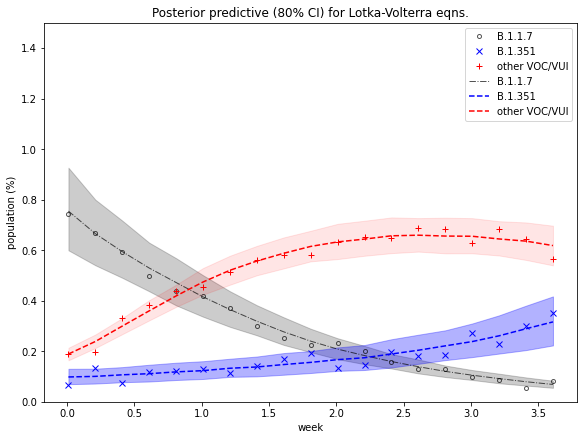

In [27]:
week_short, data_short = week[0:19], data[0:19]

def dz_dt(z, t, theta):

    z1 = z[0]
    z2 = z[1]
    z3 = z[2]
    a1, a11, a12, a13, a21, a2, a22, a23, a3, a31, a32, a33 = (
        theta[..., 0],
        theta[..., 1],
        theta[..., 2],
        theta[..., 3],
        theta[..., 4],
        theta[..., 5],
        theta[..., 6],
        theta[..., 7],
        theta[..., 8],
        theta[..., 9],
        theta[..., 10],
        theta[..., 11]
    )
    dz1_dt = a1 * z1 * (1 - (a11 * z1 + a12 * z2 + a13 * z3))
    dz2_dt = a2 * z2 * (1 - (a21 * z1 + a22 * z2 + a23 * z3))
    dz3_dt = a3 * z3 * (1 - (a31 * z1 + a32 * z2 + a33 * z3))
    return jnp.stack([dz1_dt, dz2_dt, dz3_dt])


def model(N, y=None):
    # initial population
    z_init = numpyro.sample("z_init", dist.LogNormal(jnp.log(10), 1).expand([3]))
    # measurement times
    ts = jnp.arange(float(N))
    theta = numpyro.sample(
        "theta",
        dist.TruncatedNormal(
            low=0.0,
            loc=jnp.array([1.0, 1.0, 1.0, 1.0,1.0,1.0, 1.0,1.0,1.0, 1.0,1.0,1.0]),
            scale=jnp.array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]),
        ),
    )
    z = odeint(dz_dt, z_init, ts, theta, rtol=1e-7, atol=1e-6, mxstep=1000)
    sigma = numpyro.sample("sigma", dist.LogNormal(-1, 1).expand([3]))
    numpyro.sample("y", dist.LogNormal(jnp.log(z), sigma), obs=y)
    
mcmc = MCMC(
    NUTS(model, dense_mass=True),
    500,
    500,
    num_chains=2,
    progress_bar=False if "NUMPYRO_SPHINXBUILD" in os.environ else True,
)

mcmc.run(PRNGKey(1), N=data_short.shape[0], y=data_short)
mcmc.print_summary()

pop_pred = Predictive(model, mcmc.get_samples())(PRNGKey(2), data_short.shape[0])["y"]
mu, pi = jnp.mean(pop_pred, 0), jnp.percentile(pop_pred, (10, 90), 0)

plt.figure(figsize=(8, 6), constrained_layout=True)
plt.plot(week_short, data_short[:, 0], "ko", mfc="none", ms=4, label="B.1.1.7", alpha=0.67)
plt.plot(week_short, data_short[:, 1], "bx", label="B.1.351")
plt.plot(week_short, data_short[:, 2], "r+", label="other VOC/VUI")
plt.plot(week_short, mu[:, 0], "k-.", label="B.1.1.7", lw=1, alpha=0.67)
plt.plot(week_short, mu[:, 1], "b--", label="B.1.351")
plt.plot(week_short, mu[:, 2], "r--", label="other VOC/VUI")
plt.fill_between(week_short, pi[0, :, 0], pi[1, :, 0], color="k", alpha=0.2)
plt.fill_between(week_short, pi[0, :, 1], pi[1, :, 1], color="b", alpha=0.3)
plt.fill_between(week_short, pi[0, :, 2], pi[1, :, 2], color="r", alpha=0.1)
plt.gca().set(ylim=(0, 1.5), xlabel="week", ylabel="population (%)")
plt.title("Posterior predictive (80% CI) for Lotka-Volterra eqns.")
plt.legend()
plt.show()